In [53]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, ToPILImage

!pip install torchinfo


In [54]:
# Loads CIFAR10 into training_data
# Filepath = root, training indicator true, downloads if not available
# Option to transform to 3d tensors
training_data = datasets.CIFAR10(
    root = ".data",
    train = True,
    download = True,
    transform = ToTensor(),
    #target_transform = Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)


# Loads CIFAR10 into testing_data
# Filepath = root, training indicator false, downloads if not available
# Option to transform to 3d tensors
testing_data = datasets.CIFAR10(
    root = ".data",
    train = False,
    download = True,
    transform = ToTensor(),
    #target_transform = Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

Files already downloaded and verified
Files already downloaded and verified


In [55]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [56]:
# Provides a dictionary for mapping label id to label text
labels_map = (
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck"
)

In [57]:
# Function to display training data
def display_training(size):
    figure = plt.figure(figsize=(8,8))
    cols, rows = size, size
    for i in range(1, cols * rows + 1):
        random_index = np.random.randint(len(training_data))
        img, label = training_data[random_index]
        plt.subplot(rows, cols, i)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(img, cmap=plt.cm.binary)
        plt.xlabel(labels_map[label])
    plt.show()
#display_training(4)

In [58]:
# Loads data sets into DataLoader for batch processing
train_dataloader = DataLoader(training_data, batch_size=4, shuffle=True, num_workers = 2)
test_dataloader = DataLoader(testing_data, batch_size=4, shuffle=True, num_workers = 2)

Feature batch shape: torch.Size([4, 3, 32, 32])
Labels batch shape: torch.Size([4])
Label: airplane


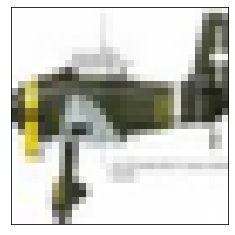

In [59]:
# Iterating through DataLoader
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0]
label = train_labels[0]
plt.imshow(ToPILImage()(img), cmap="gray")
plt.xticks([])
plt.yticks([])
print(f"Label: {labels_map[train_labels[0]]}")
plt.show()

In [60]:
#Set up CNN
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.fc1 = nn.Linear(128 * 2 * 2, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

net = Net()

if train_on_gpu:
    net.cuda()


In [61]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [62]:
from torchinfo import summary

batch_size = 4
summary(net, input_size=(batch_size, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      --                        --
├─Conv2d: 1-1                            [4, 16, 32, 32]           448
├─MaxPool2d: 1-2                         [4, 16, 16, 16]           --
├─Conv2d: 1-3                            [4, 32, 16, 16]           4,640
├─MaxPool2d: 1-4                         [4, 32, 8, 8]             --
├─Conv2d: 1-5                            [4, 64, 8, 8]             18,496
├─MaxPool2d: 1-6                         [4, 64, 4, 4]             --
├─Conv2d: 1-7                            [4, 128, 4, 4]            73,856
├─MaxPool2d: 1-8                         [4, 128, 2, 2]            --
├─Linear: 1-9                            [4, 512]                  262,656
├─Linear: 1-10                           [4, 128]                  65,664
├─Linear: 1-11                           [4, 64]                   8,256
├─Linear: 1-12                           [4, 10]             

In [63]:
# code based on https://shonit2096.medium.com/cnn-on-cifar10-data-set-using-pytorch-34be87e09844

from typing import NewType
# number of epochs to train the model
n_epochs = 15
#List to store loss to visualize
train_losslist = []
test_losslist = []
test_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    test_loss = 0.0
    
    ###################
    # train the model #
    ###################
    net.train()
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        if train_on_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        output = net(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        # update training loss
        train_loss += loss.item()*inputs.size(0)
        #if i % 2000 == 1999:    # print every 2000 mini-batches
        #    print(f'Training - [{epoch + 1}, {i + 1:5d}] loss: {train_loss / 2000:.3f}')

        
    ######################    
    # validate the model #
    ######################
    net.eval()
    for i, data in enumerate(test_dataloader, 0):
        inputs, labels = data
        if train_on_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()
        output = net(inputs)
        loss = criterion(output, labels)
        # update average test loss 
        test_loss += loss.item()*inputs.size(0)
        #if i % 2000 == 1999:    # print every 2000 mini-batches
        #    print(f'Testing - [{epoch + 1}, {i + 1:5d}] loss: {train_loss / 2000:.3f}')
    
    # calculate average loss
    train_loss = train_loss/len(train_dataloader.dataset)
    test_loss = test_loss/len(test_dataloader.dataset)
    # put loss in list, to be shown in graph
    train_losslist.append(train_loss)
    test_losslist.append(test_loss)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tTest Loss: {:.6f}'.format(
        epoch, train_loss, test_loss))
    
    # save model if validation loss has decreased
    if test_loss <= test_loss_min:
        print('New best model found ({:.6f} --> {:.6f}), saving'.format(
        test_loss_min,
        test_loss))
        torch.save(net.state_dict(), 'model_cifar.pt')
        test_loss_min = test_loss


Epoch: 1 	Training Loss: 2.294055 	Test Loss: 2.096365
New best model found (inf --> 2.096365), saving
Epoch: 2 	Training Loss: 1.882055 	Test Loss: 1.644619
New best model found (2.096365 --> 1.644619), saving
Epoch: 3 	Training Loss: 1.455700 	Test Loss: 1.276026
New best model found (1.644619 --> 1.276026), saving
Epoch: 4 	Training Loss: 1.196352 	Test Loss: 1.117441
New best model found (1.276026 --> 1.117441), saving
Epoch: 5 	Training Loss: 1.021892 	Test Loss: 1.023502
New best model found (1.117441 --> 1.023502), saving
Epoch: 6 	Training Loss: 0.893674 	Test Loss: 0.909709
New best model found (1.023502 --> 0.909709), saving
Epoch: 7 	Training Loss: 0.791521 	Test Loss: 0.974686
Epoch: 8 	Training Loss: 0.706570 	Test Loss: 0.861101
New best model found (0.909709 --> 0.861101), saving
Epoch: 9 	Training Loss: 0.639695 	Test Loss: 0.837762
New best model found (0.861101 --> 0.837762), saving
Epoch: 10 	Training Loss: 0.574160 	Test Loss: 0.829092
New best model found (0.837762

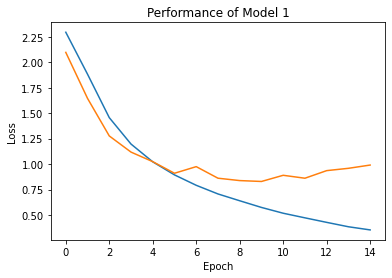

In [64]:
plt.plot([*range(n_epochs)], train_losslist)
plt.plot([*range(n_epochs)], test_losslist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Performance of Model 1")
plt.show()

In [65]:
#load best model state
net.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

In [66]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

net.eval()
# iterate over test data
for data, target in test_dataloader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = net(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(4):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_dataloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            labels_map[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (labels_map[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


Test Loss: 0.829092

Test Accuracy of airplane: 73% (736/1000)
Test Accuracy of automobile: 83% (837/1000)
Test Accuracy of  bird: 67% (675/1000)
Test Accuracy of   cat: 49% (499/1000)
Test Accuracy of  deer: 69% (692/1000)
Test Accuracy of   dog: 57% (571/1000)
Test Accuracy of  frog: 77% (778/1000)
Test Accuracy of horse: 77% (779/1000)
Test Accuracy of  ship: 85% (859/1000)
Test Accuracy of truck: 84% (842/1000)

Test Accuracy (Overall): 72% (7268/10000)
